In [1]:
# Load libraries
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation
from sklearn.model_selection import GridSearchCV # find optimal hyperparameters
import matplotlib.pyplot as plt

In [2]:
# load_data
df = pd.read_csv('mushroom_cleaned.csv')
df.head()

,cap-diameter,cap-shape,gill-attachment,gill-color,stem-height,stem-width,stem-color,season,class
0,1372,2,2,10,3.807467,1545,11,1.804273,1
1,1461,2,2,10,3.807467,1557,11,1.804273,1
2,1371,2,2,10,3.612496,1566,11,1.804273,1
3,1261,6,2,10,3.787572,1566,11,1.804273,1
4,1305,6,2,10,3.711971,1464,11,0.943195,1


In [3]:
#split dataset into features and target variable
X = df.iloc[:, 0:8] 
y = df.iloc[:, -1:]

In [4]:
# split data into train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, shuffle= True, random_state=1)

In [5]:
len(X_train), len(X_test)

(43228, 10807)

In [6]:
# build the model
# create decision tree model object 
model = DecisionTreeClassifier()

# train model 
model = model.fit(X_train, y_train)

# predict the response for X_test
y_pred = model.predict(X_test)

In [7]:
# Evaluate model : accuracy
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.9785324326825205


## Optimize performance

In [8]:
# 1. Change criterion: gini(default), entropy, log-loss
model = DecisionTreeClassifier(criterion='entropy')

# train model 
model = model.fit(X_train, y_train)

# predict the response for X_test
y_pred = model.predict(X_test)

# Evaluate model : accuracy
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.9812158785972055


In [9]:
# 2. Pre pruning 
# + max_depth: int, default = None
# + min_samples_split: int or float, default = 2
# + min_samples_leaf: int or float, default = 1
# should train for 10 - 40 depth tree to see the increase

def decisionTree(crite): 
    acc = []
    for i in range (19, 36): 
        model = DecisionTreeClassifier(criterion= crite, max_depth= i)

        # train model 
        model = model.fit(X_train, y_train)

        # predict the response for X_test
        y_pred = model.predict(X_test)

        # Evaluate model : accuracy
        accuracy = metrics.accuracy_score(y_test, y_pred)
        acc.append(accuracy)
    return acc

entropy = decisionTree('entropy')
gini = decisionTree('gini')
logLoss = decisionTree('log_loss')

Text(0, 0.5, 'Accuracy')

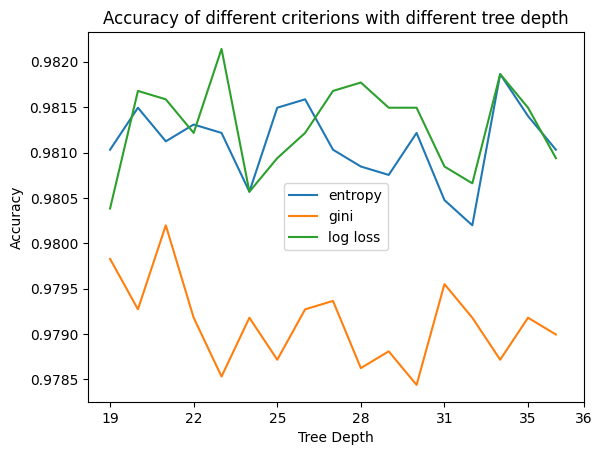

In [11]:
plt.plot(entropy, label = 'entropy')
plt.plot(gini, label = 'gini')
plt.plot(logLoss, label = 'log loss')
plt.legend()
plt.title('Accuracy of different criterions with different tree depth')
plt.xticks(ticks=(0, 3, 6, 9, 12, 15, 17), labels=(19, 22, 25, 28, 31, 35, 36))
plt.xlabel("Tree Depth")
plt.ylabel("Accuracy")


In [13]:
# optimal hyperparameters using GridSearchCV
parameter = {
    'criterion' :['entropy','log_loss'],
    'max_depth':[21, 22, 23, 24, 25, 26],
    'min_samples_split' : [1, 2, 3, 4],
    'min_samples_leaf': [1, 2, 3, 4],
}

model = DecisionTreeClassifier()
cv = GridSearchCV(model, param_grid=parameter, cv=5)
cv.fit(X_train, y_train)

c:\Users\ADMIN\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
240 fits failed out of a total of 960.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
240 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\ADMIN\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\ADMIN\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py", line 1145, in wrapper
    estimator._validate_params()
  File "c:\Users\ADMIN\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['entropy', 'log_loss'],
                         'max_depth': [21, 22, 23, 24, 25, 26],
                         'min_samples_leaf': [1, 2, 3, 4],
                         'min_samples_split': [1, 2, 3, 4]})

In [14]:
cv.score(X_test,y_test)

0.9815860090681965

In [15]:
cv.best_params_

{'criterion': 'entropy',
 'max_depth': 25,
 'min_samples_leaf': 1,
 'min_samples_split': 2}

In [16]:
# Post pruning 
# 1. First: Train a model with fully growth tree
model = DecisionTreeClassifier(criterion='entropy')

# train model 
model = model.fit(X_train, y_train)

# predict the response for X_test
y_pred = model.predict(X_test)

# Evaluate model : accuracy
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.98103081336171


In [17]:
# Cost-complexity pruning (Post-pruning)
path = model.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

# Train a series of decision trees with different alpha values
pruned_models = []
for ccp_alpha in ccp_alphas:
    pruned_model = DecisionTreeClassifier(criterion="gini", ccp_alpha=ccp_alpha)
    pruned_model.fit(X_train, y_train)
    pruned_models.append(pruned_model)

# Find the model with the best accuracy on test data
best_accuracy = 0
best_pruned_model = None
for pruned_model in pruned_models:
    accuracy = pruned_model.score(X_test, y_test)
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_pruned_model = pruned_model
# Model Accuracy after pruning
accuracy_after_pruning = best_pruned_model.score(X_test, y_test)
print("Accuracy after pruning:", accuracy_after_pruning)


Accuracy after pruning: 0.980660682890719


In [ ]:
# 1. Random forest (Bagging): Hien
# 2. Boosting : Hiep
# 3. SVM : Hoan 
# toi thuw 6 
 